Objective
To build a model which would predict the order status (Delivered to buyer or Returned to seller)

Data Dictionary
The Order data is provided in an excel file. The columns are: Independent Features:

order_no - Unique Order Number

order_date - Date on which the order was placed

buyer - Name of the buyer

ship_city - Delivery Address City

ship_state - Delivery Address State

sku - Unique identifier of a product

description - Product description

quantity - Number of units ordered

item_total - Total amount paid by the buyer

shipping_fee - Charges to ship the item

cod - Mode of payment: Cash on delivery or not

Label / Target Feature:

order_status - Status of the order


**Analysis Steps:**
* Import libraries
* Understand the data
* Handle missing values
* Format Date Feature
* Visualize Business Insigths


### Import Libraries

In [1]:
!pip install openpyxl

In [2]:
!pip install wordcloud

In [3]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.simplefilter('ignore')

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from nltk.corpus import stopwords
import string


#Libraries for vectorisation of text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

#Arbre de décision
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

#Libraries for clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl


%matplotlib inline

### Import Data


In [4]:
df = pd.read_excel('/kaggle/input/hounidataset/orders_data.xlsx')

### Undestand the Data


In [5]:
df.head()

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
0,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Mr.,"CHANDIGARH,",CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,₹449.00,NaN,NaN,Delivered to buyer
1,404-3964908-7850720,"Tue, 19 Oct, 2021, 6:05 pm IST",Minam,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer
2,171-8103182-4289117,"Sun, 28 Nov, 2021, 10:20 pm IST",yatipertin,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer
3,405-3171677-9557154,"Wed, 28 Jul, 2021, 4:06 am IST",aciya,"DEVARAKONDA,",TELANGANA,SKU: AH-J3AO-R7DN,Pure 100% Leather Block Print Rectangular Jewe...,1,NaN,NaN,Cash On Delivery,Delivered to buyer
4,402-8910771-1215552,"Tue, 28 Sept, 2021, 2:50 pm IST",Susmita,"MUMBAI,",MAHARASHTRA,SKU: KL-7WAA-Z82I,Pure Leather Sling Bag with Multiple Pockets a...,1,"₹1,099.00",₹84.96,NaN,Delivered to buyer


In [6]:
df.describe(include="all")

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
count,171,171,171,171,171,171,171,171.000000,153,145,47,171
unique,171,171,149,81,30,54,61,NaN,18,13,1,2
top,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Geetika,"MUMBAI,",MAHARASHTRA,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,NaN,₹449.00,₹84.96,Cash On Delivery,Delivered to buyer
freq,1,1,3,17,31,33,33,NaN,52,100,47,160
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.087719,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.445132,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


* There are 171 datapoints and 12 features
* order_no and date are unique
* One buyer made at most 3 orders
* City,state, sku and description need further analysis
* The ordered quantity is at most 4 but median is 1
* Item_total and shipping_fee should be converted to float
* Cash on delivery has only 1 value, so it seems like boolean
* Order status is target variable, and has 2 classes.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_no      171 non-null    object
 1   order_date    171 non-null    object
 2   buyer         171 non-null    object
 3   ship_city     171 non-null    object
 4   ship_state    171 non-null    object
 5   sku           171 non-null    object
 6   description   171 non-null    object
 7   quantity      171 non-null    int64 
 8   item_total    153 non-null    object
 9   shipping_fee  145 non-null    object
 10  cod           47 non-null     object
 11  order_status  171 non-null    object
dtypes: int64(1), object(11)
memory usage: 16.2+ KB


In [8]:
[features for features in df.columns if df[features].isnull().sum()>0]

['item_total', 'shipping_fee', 'cod']

* item_total, shipping_fee and cod has missing values, we should deal with them
* Order_data should be date dtype
* Item_total and Shipping_fee should be float or int
* Cod should be boolean
* Order_status is also should be boolean

In [9]:
df.shape

(171, 12)

In [10]:
def drop(df, *features):
    ''' To drop the features from a dataframe'''
    for i in features:
        df.drop(i, axis=1, inplace=True)

### Data Cleaning

In [11]:
# Convert city and state into uppercase
places = ['ship_city', 'ship_state']
for i in places:
    df[i] = df[i].apply(lambda x: x.upper())

In [12]:
# removing comma from city values
df['ship_city'] = df['ship_city'].apply(lambda x: x.replace(',', ''))
df['ship_state'] = df['ship_state'].apply(lambda x: x.replace(',', ''))

In [13]:
df.isnull().sum()

order_no          0
order_date        0
buyer             0
ship_city         0
ship_state        0
sku               0
description       0
quantity          0
item_total       18
shipping_fee     26
cod             124
order_status      0
dtype: int64

### Handle Missing Values
There are 3 features with missing values: cod, item_total and shipping fee

In [14]:
# imputing with mode as shipping fee is fixed based on package size and weight
df['shipping_fee'].fillna(df['shipping_fee'].mode()[0], inplace=True)

# imputing with mode as we are considering the item that is sold the most
df['item_total'].fillna(df['item_total'].mode()[0], inplace=True)

# assuming if an order is not cod would mean the mode of payment is online
df['cod'].fillna('online', inplace=True)

In [15]:
# remove rupee symbol from amount features
amounts = ['item_total', 'shipping_fee']
for i in amounts:
    df[i] = df[i].apply(lambda x: x.replace(',', ''))        # remove the commas in amounts greater than 1000
    df[i] = df[i].apply(lambda x: x[1:])

In [16]:
# change data types
i = 'int64'
f = 'float64'
df = df.astype({'item_total': f, 'shipping_fee': f, 'quantity': i})

In [17]:
df.head(3)

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
0,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Mr.,CHANDIGARH,CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer
1,404-3964908-7850720,"Tue, 19 Oct, 2021, 6:05 pm IST",Minam,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer
2,171-8103182-4289117,"Sun, 28 Nov, 2021, 10:20 pm IST",yatipertin,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer


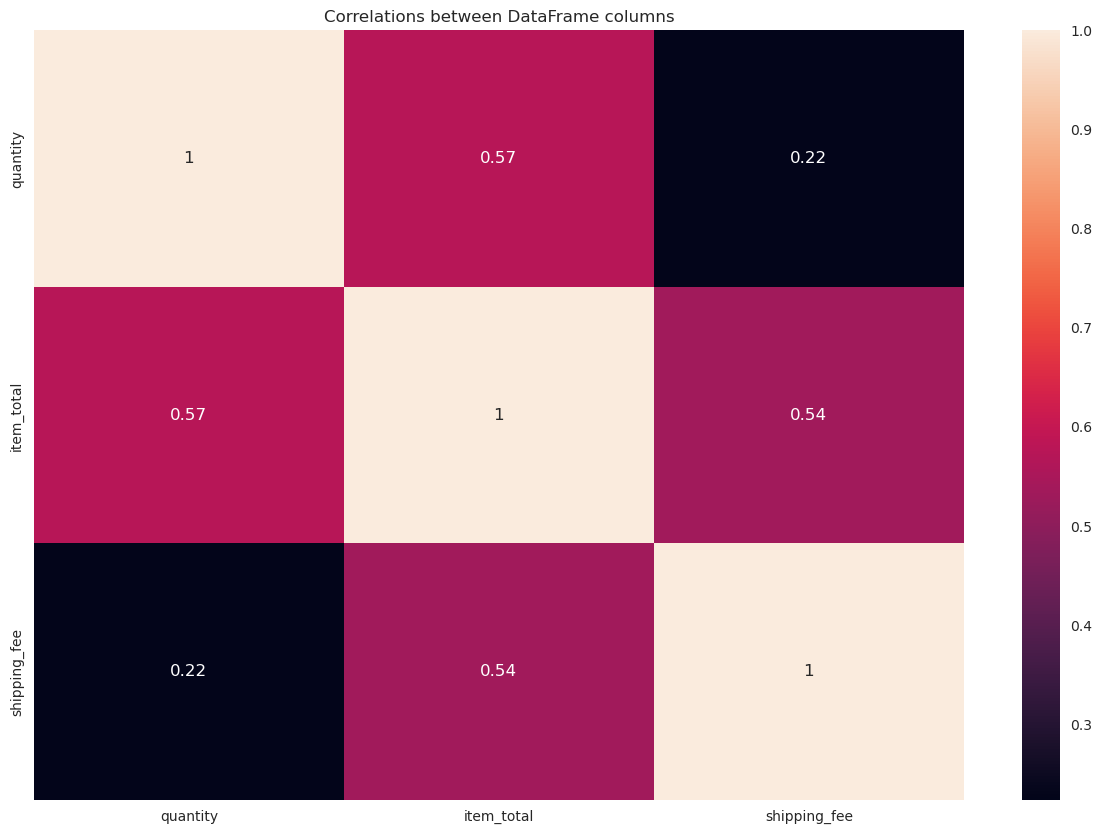

In [18]:
# Now, Let's start with visualizing the data
# 1-let's see the correlation between the columns
plt.figure(figsize = (15,10))
plt.title('Correlations between DataFrame columns')
sns.heatmap(df.corr(),annot = True)
plt.show()

print()

### Drawing Business Insights:
We will try to answer few questions:

* Is order success dependant on mode of payment?
* Sales Trend (Sales Pattern over the period)
* Which days of the week draw more sales?
* People from which states are ordering the most
* Which are the top sold products?
* What percentage of orders have been returned?
* Most popular keywords among the customers

In [19]:
df[['cod', 'order_status', 'item_total']].groupby(['cod', 'order_status']).sum().reset_index()

,cod,order_status,item_total
0,Cash On Delivery,Delivered to buyer,23812.0
1,Cash On Delivery,Returned to seller,2245.0
2,online,Delivered to buyer,68508.0
3,online,Returned to seller,2694.0


In [20]:
fig = px.histogram(df, x="cod", y="item_total", color='order_status', barmode='group', height=400)
fig.show()

We see that most of the orders were prepaid and the percentage of return orders is more in cod mode.

### Format date

In [21]:


# extract year, month, day, and time from date feature
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['date'] = pd.DatetimeIndex(df['order_date']).date
df['time'] = pd.DatetimeIndex(df['order_date']).time
df['month_name'] = pd.DatetimeIndex(df['order_date']).month_name()
df['day_name'] = pd.DatetimeIndex(df['order_date']).day_name()


In [22]:
drop(df, 'order_date')
df.head(2)

,order_no,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,date,time,month_name,day_name
0,405-9763961-5211537,Mr.,CHANDIGARH,CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer,2021,2021-07-18,22:38:00,July,Sunday
1,404-3964908-7850720,Minam,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer,2021,2021-10-19,18:05:00,October,Tuesday


In [23]:
# Extracting the unique identifier
df['sku'] = df['sku'].apply(lambda x: x[4:])
df.head(2)

,order_no,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,date,time,month_name,day_name
0,405-9763961-5211537,Mr.,CHANDIGARH,CHANDIGARH,2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer,2021,2021-07-18,22:38:00,July,Sunday
1,404-3964908-7850720,Minam,PASIGHAT,ARUNACHAL PRADESH,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer,2021,2021-10-19,18:05:00,October,Tuesday


In [24]:
df_sales = df[['date', 'item_total']].groupby('date').sum().reset_index()
df_sales.head(3)

,date,item_total
0,2021-06-13,175.0
1,2021-06-16,525.0
2,2021-06-17,200.0


In [25]:
fig = px.line(df_sales, x='date', y="item_total", title = 'Sales over the period')
fig.show()

There hasn't been any significant growth over the period. December month saw the maximum sales with a couple of breakthroughs.

In [26]:
df_days = df[['year', 'month_name', 'day_name', 'item_total']].groupby(['year', 'month_name', 'day_name']).sum().reset_index()
# df_days.sort_values(by=['year', 'month_name'])

In [27]:
fig = px.bar(df_days, x="month_name", y="item_total", color="day_name", title="Month-wise Sales")
fig.show()

In [28]:
df_places = df[['ship_state', 'ship_city', 'item_total']].groupby(['ship_state', 'ship_city']).sum().reset_index()
df_places.sort_values(by='item_total', ascending=False, inplace=True)

In [29]:
fig = px.sunburst(data_frame=df_places, path=['ship_state', 'ship_city'], values='item_total', title='Region-wise orders')
fig.show()

In [30]:
top_cities = df.groupby('ship_city').size().reset_index().rename(columns={0: 'Total'}).sort_values('Total', ascending=False).head()
fig = px.pie(top_cities, values='Total', names='ship_city', color_discrete_sequence=px.colors.sequential.RdBu, title='Top 5 ordering cities')
fig.show()

In [31]:
top_cities = df.groupby('sku').size().reset_index().rename(columns={0: 'Total'}).sort_values('Total', ascending=False).head()
fig = px.pie(top_cities, values='Total', names='sku', color_discrete_sequence=px.colors.sequential.BuGn_r, title='Top 5 Products')
fig.show()

In [32]:
df['order_status'].value_counts()

Delivered to buyer    160
Returned to seller     11
Name: order_status, dtype: int64

In [33]:
df_status = df[['order_status', 'item_total']]
fig = px.bar(data_frame=df_status, x='order_status', y='item_total', color='order_status', title='Success rate of orders')
fig.show()

From the above we can find the order value of each of success and return orders

# Kmeans Clustering

In [34]:
df['description'] = df['description'].apply(lambda x: x.replace('|', ''))

In [35]:
stop_words = stopwords.words('english')
stop_words.extend(['Pure', 'Leather', 'Shantiniketan', 'with', 'clean_dedsc', 'phone', 'for', 'and', 'print', 'block', 'dtype'])

In [36]:
# Remove stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return ' '.join(result)

In [37]:
# cleaned data
df['clean_desc'] = df['description'].apply(preprocess)

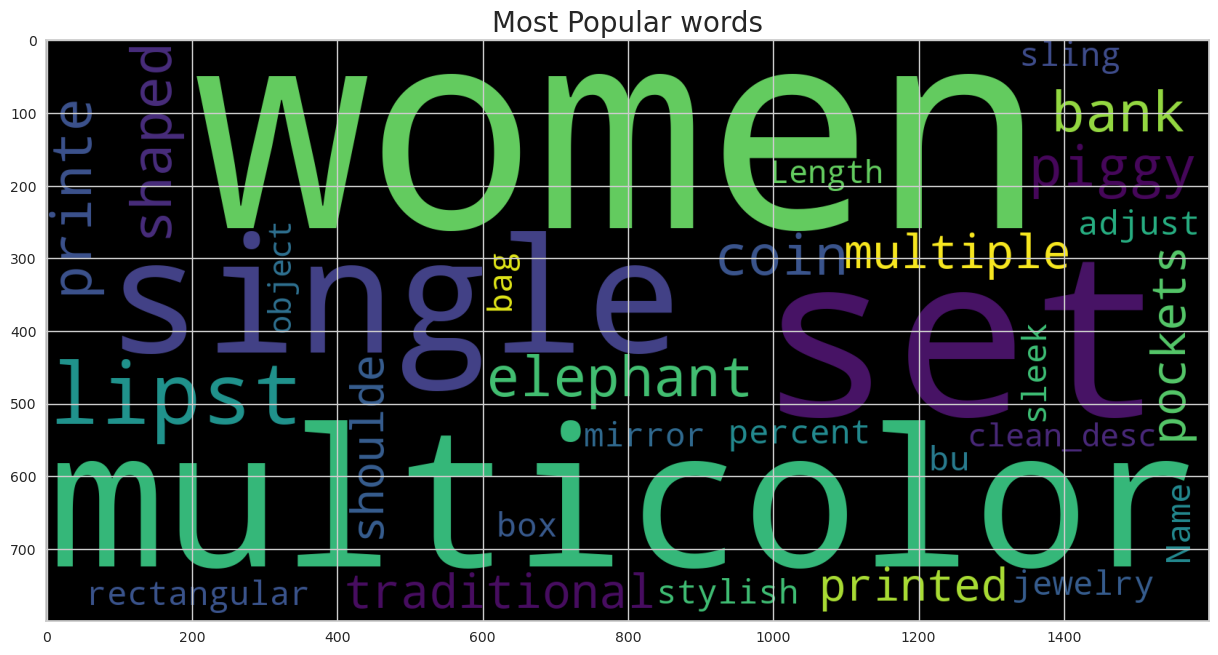

In [38]:
plt.figure(figsize=(15,10))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(str(df[df['order_status']=='Delivered to buyer'].clean_desc))
plt.title('Most Popular words', fontsize=20)
plt.imshow(wc)

<AxesSubplot:xlabel='description_cleaned'>

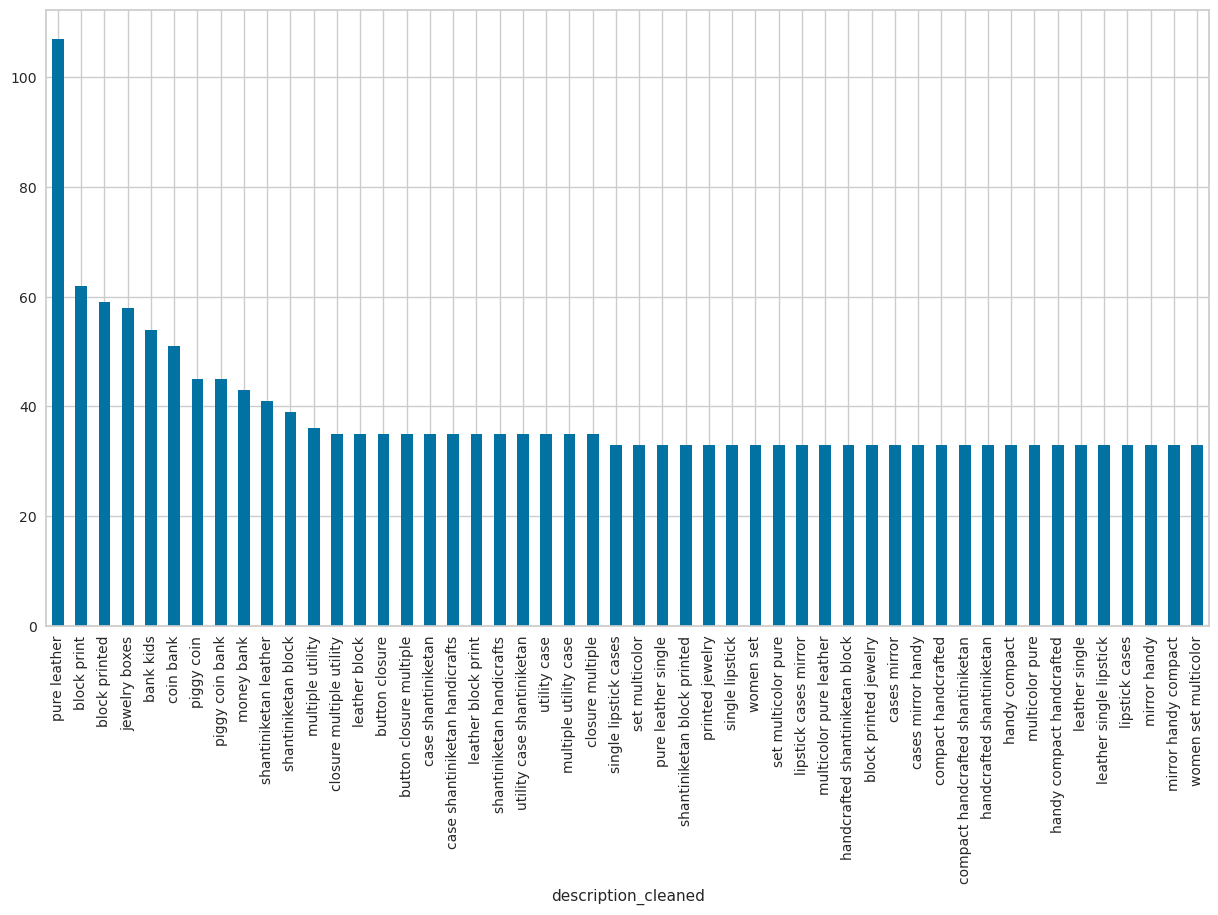

In [39]:
# Top 20 words/phrases

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,3),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['description'],50)

df2 = pd.DataFrame(common_words, columns = ['description_cleaned' , 'count'])

df2.groupby('description_cleaned').sum()['count'].sort_values(ascending=False).plot(kind = 'bar', figsize = (15,8))


### Clustering Items

In [40]:
# store all the descriptions in a series

text1 = df['description']

In [41]:
# We can categorize the items

#Remove stopwords, punctuation and numbers
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]


# Replace this list with your desired list of colors
color_names = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'white', 'gray', 'brown']

def remove_stopwords(text):
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.lower() not in stopwords.words('english')]
    return ' '.join(words_filtered)

# Remove stopwords, punctuation, and numbers
text2 = [remove_stopwords(x)
        .translate(str.maketrans('', '', string.punctuation))
        .translate(str.maketrans('', '', string.digits))
        for x in text1]

# Stem and make lower case
def stem_sentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

text3 = pd.Series([stem_sentence(x) for x in text2])

# Remove colors
stemmed_colors = [stem_sentence(x) for x in color_names]
text4 = [' '.join([x for x in string.split() if x not in stemmed_colors]) for string in text3]

In [42]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text4)

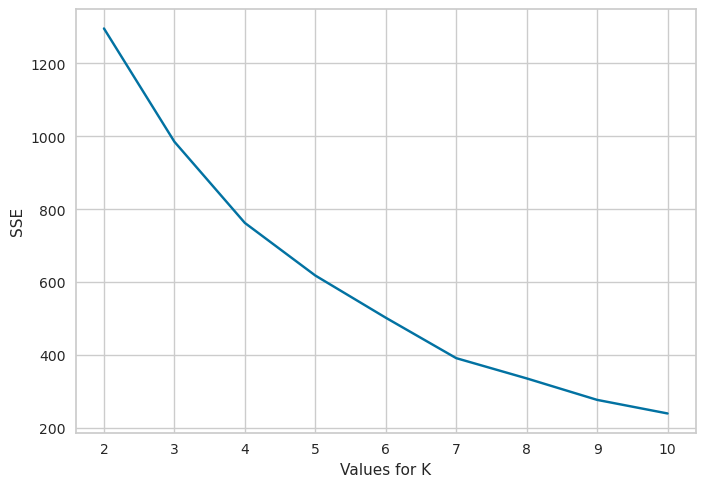

In [43]:
#Test increments of clusters using elbow method
sse={}
for k in [2,3,4,5,6,7,8,9,10]:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show()

We can see the first elbow at 3 clusters so let's try that. I have tried out other values of K as well but 3 gave the most logical results without creating clusters that were too small.

In [44]:
#Create clusters
kmeans = KMeans(n_clusters=3, random_state = 10)
kmeans.fit(X_cv)
df['cluster_label'] = kmeans.predict(X_cv)

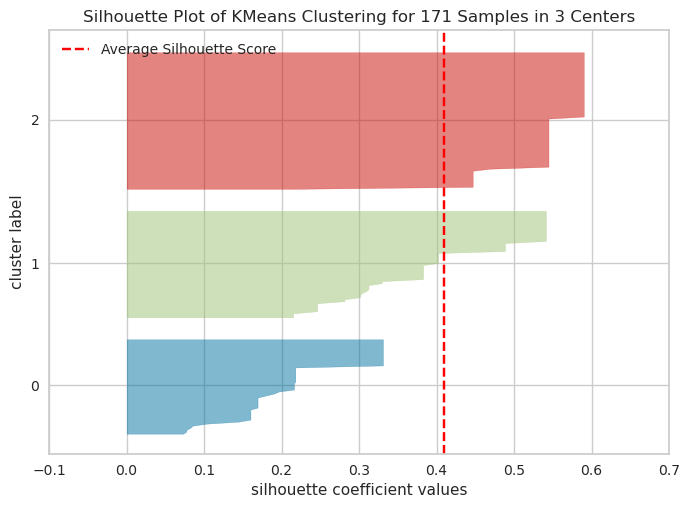

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 171 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [45]:
# Visualise the silhouette plot

visualizer = SilhouetteVisualizer(kmeans,is_fitted = True,colors='yellowbrick')

visualizer.fit(X_cv)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Although the blue cluster is below the average line, the silhouette plot of K=3 is comparitively better when compared to other values. Also K = 3 , works out well logically. We can visualise the clusters with a word cloud as shown below.

## Let's bin the products into categories


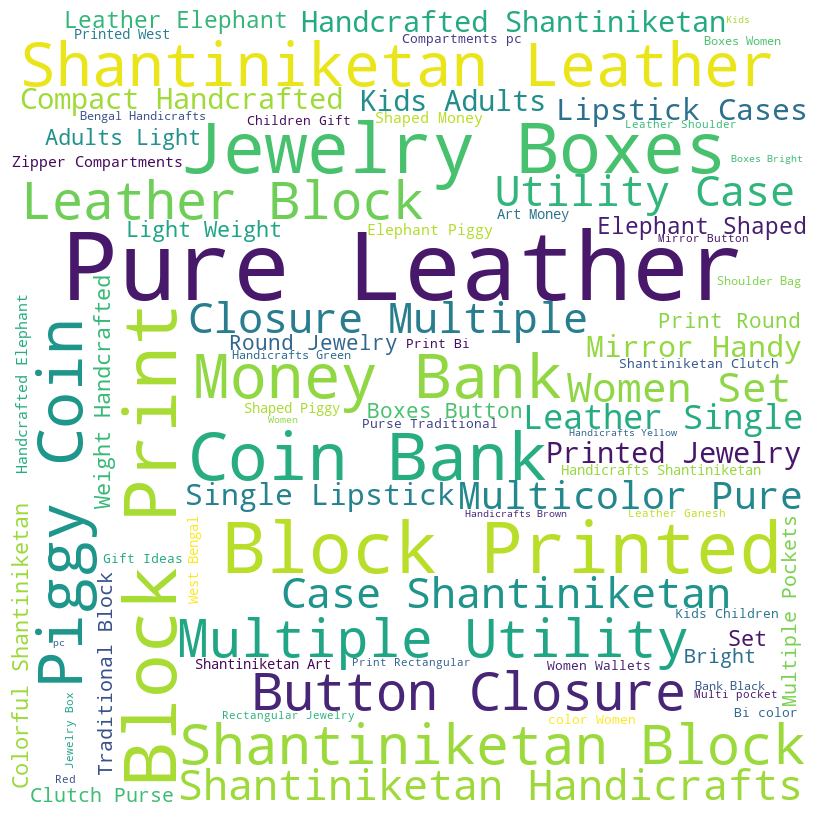

In [46]:


all_text = ''

for document in df['description']:
    all_text = all_text + ' ' + document


wordcloud_image = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_text)

plt.figure(figsize = (8, 8), facecolor = None)

plt.imshow(wordcloud_image)
plt.axis("off")
plt.tight_layout(pad = 0)

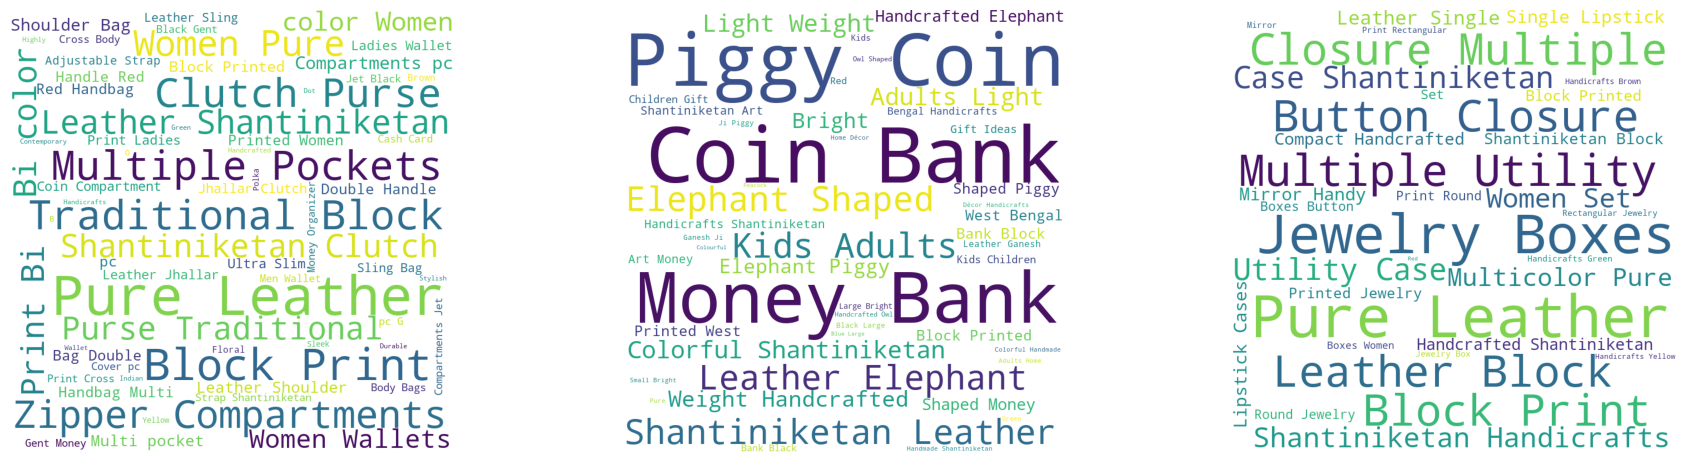

In [47]:
plt.figure(figsize = (20,30))

for i in range(3):

    plt.subplot(1,3,i+1)

    all_text = ''

    for document in df[df['cluster_label']==i]['description']:
        all_text = all_text + ' ' + document


    wordcloud_image = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10, random_state = 10).generate(all_text)

    plt.imshow(wordcloud_image)
    plt.axis("off")
    plt.tight_layout(pad = 10)

### This has helped us to identify 3 clusters: 
1. Bags and Wallets : Purse, Bag, Wallet, Clutch
2. Money Bank
3. Multi-utility Beauty products - Jewelery Box, Lipstick Cases, Mirrors etc

## Same but with KNN

In [48]:
# Preprocessing
df['description'] = df['description'].apply(lambda x: x.replace('|', ''))
stop_words = stopwords.words('english')
stop_words.extend(['Pure', 'Leather', 'Shantiniketan', 'with', 'clean_dedsc', 'phone', 'for', 'and', 'print', 'block', 'dtype'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
    return ' '.join(result)
df['clean_desc'] = df['description'].apply(preprocess)

# Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_desc'])

# KNN Clustering
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, df['order_status'])

# Predict the clusters for the data
predicted_clusters = knn.predict(X)

# Add the predicted clusters to the dataframe
df['predicted_cluster'] = predicted_clusters

# Print the count of items in each predicted cluster
print(df['predicted_cluster'].value_counts())


Delivered to buyer    171
Name: predicted_cluster, dtype: int64


In the above code, we first load the data and preprocess it as we did in the KMeans Clustering code. Then, we use the TfidfVectorizer to convert the preprocessed text into numerical data. We then initialize the KNeighborsClassifier with the number of neighbors as 5 and fit the data to the classifier. Finally, we predict the clusters for the data and add them to the dataframe. We print the count of items in each predicted cluster.


## Same with ADD 

In [49]:


# Define the input and output variables
X = df['clean_desc']
y = df['order_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the input variables using the TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9428571428571428


Ce code utilise le vecteur TF-IDF pour vectoriser les données d'entrée, puis crée un arbre de décision avec la bibliothèque Scikit-learn. Enfin, il évalue les performances du modèle en calculant l'exactitude (accuracy) sur le jeu de test.

## Same with SVM

In [50]:
# Define the input and output variables
X = df['clean_desc']
y = df['order_status']

# Vectorize the input variables using the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SVM model and fit it to the training data
model = SVC(kernel='linear', C=1, gamma='scale')
model.fit(X_train, y_train)

# Predict the order_status on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9428571428571428


Ce code utilise le vecteur TF-IDF pour vectoriser les données d'entrée, puis crée un modèle SVM avec la bibliothèque scikit-learn. Le modèle est entraîné sur le jeu de données d'entraînement et évalué sur le jeu de données de test.

In [51]:
# Assigning Names to the cluster

cluster_names_dict = {0: 'Bags and Wallets', 1: 'Money Bank', 2: 'Multi-utility Beauty Products'}

df['cluster_label'] = df['cluster_label'].map(cluster_names_dict)

Now our product categories are ready to use for furthur EDA

# Furthur Insights

# Top 10s

### The Top 10 customers

Text(0, 0.5, 'Number of Orders')

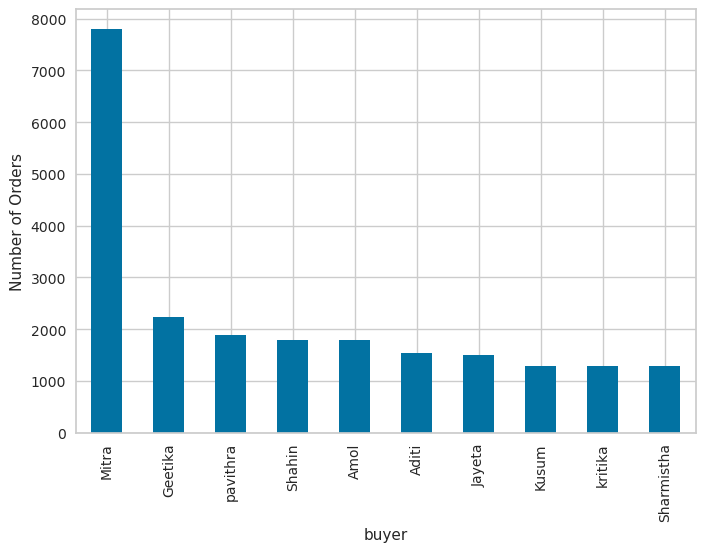

In [52]:
df.groupby(['buyer'])['item_total'].sum().sort_values(ascending = False).iloc[:10].plot(kind = 'bar')

plt.ylabel('Number of Orders')

### Same with Kmeans

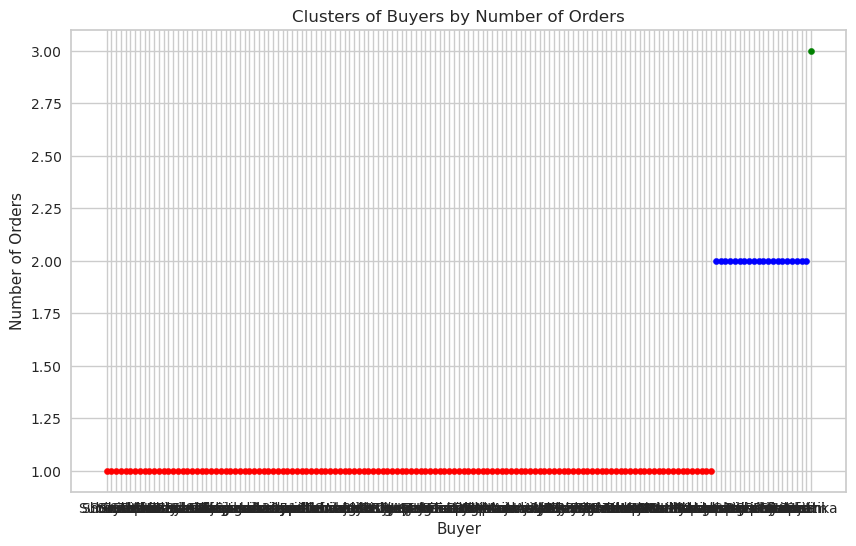

In [53]:
# Group by buyer and count their orders
buyer_orders = df.groupby(['buyer'])['order_no'].count().sort_values(ascending=False).reset_index()
X = buyer_orders[['order_no']]

# Scale the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the KMeans algorithm to cluster the buyers
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Add the labels to the original DataFrame
buyer_orders['cluster'] = labels

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
colors = {0: 'red', 1: 'blue', 2: 'green'}
grouped = buyer_orders.groupby('cluster')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='buyer', y='order_no', color=colors[key])
plt.title('Clusters of Buyers by Number of Orders')
plt.xlabel('Buyer')
plt.ylabel('Number of Orders')
plt.show()


### The top 10 cities with highest total sales

Text(0, 0.5, 'Total Sales')

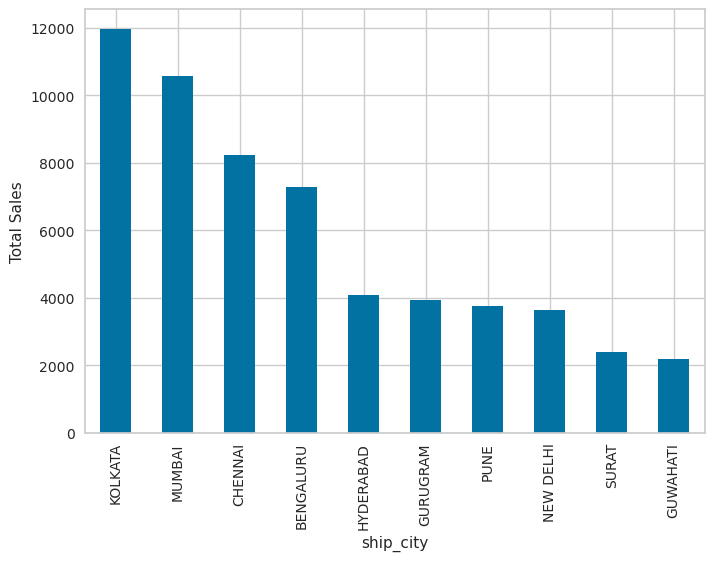

In [54]:
df.groupby(['ship_city'])['item_total'].sum().sort_values(ascending = False).iloc[:10].plot(kind = 'bar')

plt.ylabel('Total Sales')

Shipping to Kolkata and Mumbai provide the most sales.

### Which are the top 10 products with maximum orders?

Text(0, 0.5, 'Count')

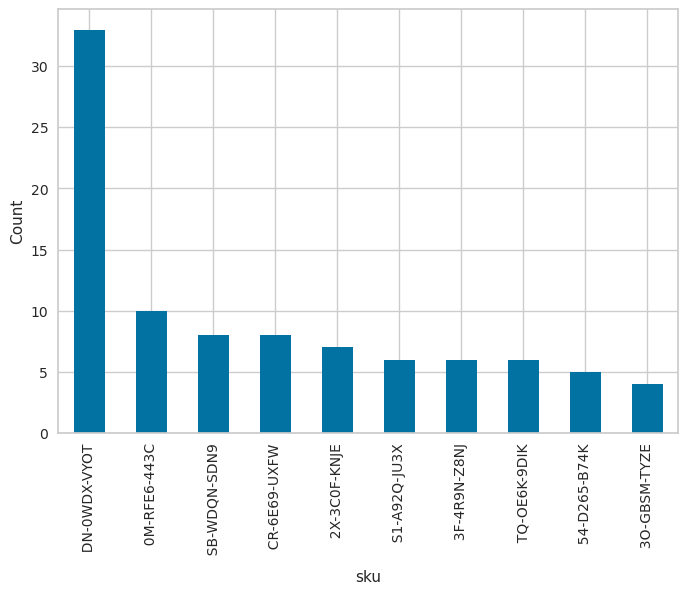

In [55]:
df.groupby(['sku']).size().sort_values(ascending = False).iloc[:10].plot(kind = 'bar')

plt.ylabel('Count')

### Conclusions
We have extracted quite a few key inferences:

* The dataset came with some missing values in 2 of its features.
* Order return rates are higher in COD type orders.
* The sales has been stagnant throughout with few breakthroughs in December.
* We visualized the sales across the months grouped by day of week to find that Sundays and Wednesdays dominate over the sales whereas the least contributor turned out to be the Saturdays.
* We saw the region wise order amounts.
* Top ordering cities are: Mumbai, Kolkata, Bangalore, Chennai and Pune.
* We identified the top selling products.
* The Barplot of order status tells us that there is less than 10% of return orders.
* In the word cloud we see which are the most popular categories among the customers.